In [1]:
import os
import sys
from pathlib import Path

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
sys.path.append(str(Path(os.getcwd()).parent))

In [35]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from torch import Tensor

from models.classifier import AmNewsClassifier, load_dataset, SavedModel
from preprocessing.pipeline import PreprocessingPipeline
from tools.load_scraped import load_scraped

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import torch

### Loading Dataset


In [3]:
data = pd.read_csv("../data/am_news_corpus.csv")

### Scrape Additional Dataset
To enhance the dataset we already had, we performed web scraping on a BBC website to gather additional Amharic text data. In this cell, we are loading the scraped data stored in a JSON file, converting it into a pandas DataFrame for easier processing.


In [4]:
scraped_dataset = load_scraped("../scraped_data/bbc_news.json")
scraped_data = pd.DataFrame(map(lambda x: x.__dict__, scraped_dataset))
scraped_data.count()

title       2334
content     2334
category    2334
dtype: int64

#### Dataset Exploring

In [5]:
scraped_data.head()

,title,content,category
0,ሪያል ማድሪድ 1 ቢሊዮን ዩሮ ትርፍ በማግኘት የመጀመሪያ ክለብ ሲሆን ዩና...,የስፔኑ ሪያል ማድሪድ አንድ ቢሊዮን ዶላር ዓመታዊ ትርፍ በማጋበስ የመጀመ...,Sports
1,በማንቸስተር ዩናይትድ ታሪክ ደካማው ቡድን ሳይሆን አይቀርም- ሩበን አሞሪም,የማንቸስተር ዩናይትዱ አሰልጣኝ ሩበን አሞሪም ቡድናቸው በክለቡ 147 ዓመ...,Sports
2,"አርሰናል በሜዳው ከቪላ አቻ ቢወጣም አርቴታ ""በልጆቼ ኮርቻለሁ"" አሉ",አርሰናል በሜዳው አስተን ቪላን አስተናግዶ በሁለት ጎል ልዩነት መምራት ቢ...,Sports
3,አርሰናል ከአስተን ቪላ - ማን ይረታል? የፕሪሚዬር ሊግ ጨዋታዎች ግምት,ኒውካስል በታሪኩ ለመጀመሪያ ጊዜ በተከታታይ 10 ጨዋታዎች ድል ሊቀናው ይ...,Sports
4,አርሰናል ከቶተንሀም፡ ማን ያሸንፋል? የፕሪሚዬር ሊግ ጨዋታዎች ግምት,ኖቲንግሀም ፎረስት የዘንድሮው ፕሪሚዬር ሊግ ያልተጠበቀ አስደናቂ ቡድን ሆ...,Sports


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2334 entries, 0 to 2333
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     2334 non-null   object
 1   content   2334 non-null   object
 2   category  2334 non-null   object
dtypes: object(3)
memory usage: 54.8+ KB


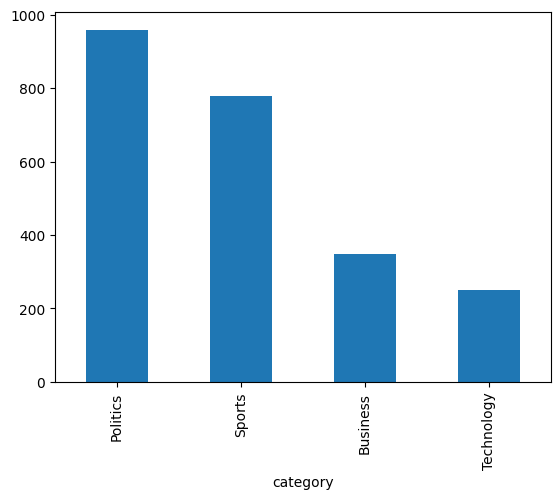

In [6]:
scraped_data["category"].value_counts().plot(kind='bar')
scraped_data.info()

### Preparing and Merging Scraped Data
Here, we are preparing the scraped dataset for integration with our existing dataset. The `content` column is renamed to `article` for consistency with the existing data format. Additionally, the `title` column, which is not required for our analysis, is dropped. Finally, the cleaned scraped data is merged with the existing dataset.


In [7]:
scraped_data = scraped_data.rename(columns={"content": "article"})
scraped_data = scraped_data.drop(columns=["title"])

data = pd.concat([data, scraped_data], axis=0)

### Preprocessing and Cleaning the Dataset
To ensure the dataset is ready for text classification, we apply several preprocessing steps:

1. **PreprocessingPipeline Class**:  
   - A custom pipeline is implemented to handle text preprocessing tasks, including:
     - Removing punctuation from Amharic text.
     - Normalizing text to handle variations in Amharic script.
     - Removing common stopwords using a predefined stopwords list.

2. **Data Cleaning**:
   - Rows with missing values are dropped to maintain data integrity.
   - The `category` column is updated to combine `Entertainment` and `Technology` into a single category called `Others`.
   - Categories are then factorized to assign numeric labels, stored in the `category_num` column.

3. **Text Preprocessing**:
   - The `article` column undergoes preprocessing through the `PreprocessingPipeline` to clean and standardize text.

4. **Shuffling the Dataset**:
   - The dataset is shuffled to ensure the training data is randomized, minimizing bias during model training.

5. **Text Preprocessing Functions**:
   - `remove_punctuation`: Removes Amharic-specific punctuation characters.
   - `normalize`: Maps different representations of Amharic characters to a standard form.
   - `remove_stopwords`: Filters out frequently used words (stopwords) that do not contribute meaningfully to text classification.

These preprocessing steps standardize the dataset, improving the performance of downstream machine learning models.


In [8]:
preprocess = PreprocessingPipeline()
data = data.dropna()

# Rename entertainment and technology as Others
data['category'] = data['category'].replace(['Entertainment', 'Technology'], 'Others')

data["category_num"] = pd.factorize(data["category"])[0]
data["article"] = data["article"].apply(preprocess)

# shuffle the df
data = data.sample(frac=1, random_state=4).reset_index(drop=True)

### Exploring and Visualizing the Dataset
In this step, we explore the distribution and structure of the dataset:

1. **Category Distribution**:
   
2. **Dataset Overview**:
   
These insights help us understand the dataset's composition and identify potential issues like class imbalance or missing data.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64249 entries, 0 to 64248
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article       64249 non-null  object
 1   category      64249 non-null  object
 2   category_num  64249 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


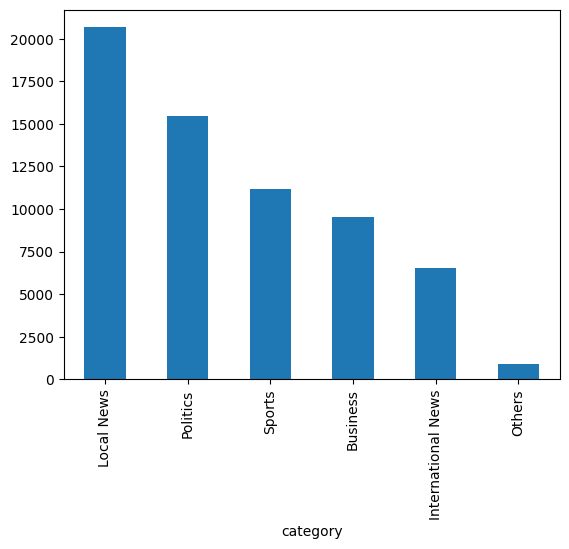

In [9]:
data["category"].value_counts().plot(kind='bar')
data.info()

In [10]:
articles, labels = data["article"], data["category_num"]

### Splitting the Dataset into Training and Testing Sets
Here, we split the dataset into training and testing subsets to evaluate the performance of our text classification model:

1. **Defining the Split Ratio**:
   - A split ratio of 80% training and 20% testing (`train_split = 0.8`) is used to ensure the model has sufficient data for training while retaining enough data for testing.

2. **Calculating the Split Index**:
   - The split index is determined based on the total number of articles. The training set includes all data up to the split index, and the testing set includes data from the split index onward.

3. **Creating Training and Testing Subsets**:
   - `articles_train` and `labels_train`: Contain the training articles and corresponding labels.
   - `articles_test` and `labels_test`: Contain the testing articles and corresponding labels.

This division ensures the model is trained on a majority of the data while being evaluated on unseen data to measure its generalization ability.


In [11]:
train_split = 0.8
split_idx = int(articles.count() * train_split)

articles_train, labels_train = articles[:split_idx], labels[:split_idx]
articles_test, labels_test = articles[split_idx:], labels[split_idx:]

### Vectorization of Text Data
To transform textual data into a numerical format suitable for machine learning models, we use the TF-IDF (Term Frequency-Inverse Document Frequency) approach:

This step prepares the text data for input into machine learning models while saving computational effort by reusing an already trained vectorizer.


In [ ]:
# vectorizer = TfidfVectorizer(analyzer='word', max_features=512, ngram_range=(1, 3))
# vectorizer.fit(articles_train)
# with open("../models/trained/tfidfvectorizer.pkl", "wb") as f:
#     pickle.dump(vectorizer, f)
    
with open("../models/trained/tfidfvectorizer.pkl", "rb") as f:
    vectorizer: TfidfVectorizer = pickle.load(f)

### Transforming Data for Model Training and Testing
Here, we prepare the dataset for machine learning by converting textual data into numerical feature representations:

1. **Feature Transformation**:
   - The training and testing articles are transformed into numerical vectors using the pre-trained TF-IDF vectorizer. This step captures the importance of words and their combinations (e.g., unigrams, bigrams, and trigrams) in the text data.

2. **Label Preparation**:
   - The corresponding labels for the training and testing datasets are extracted, aligning them with their respective feature sets.

The resulting transformed data serves as the input for training and evaluating the classification model.


In [14]:
X_train, y_train = vectorizer.transform(articles_train).toarray(), labels_train.array
X_test, y_test = vectorizer.transform(articles_test).toarray(), labels_test.array

### Preparing Validation Dataset and Data Loaders
To ensure robust model evaluation, we further split the training data into a smaller validation set and prepare data loaders for efficient batching:

1. **Creating a Validation Dataset**:
   - A subset of the training dataset is allocated for validation (`val_size = 1000`). This helps monitor the model's performance on unseen data during training.

2. **Updating Training Dataset**:
   - The remaining training data is used for model training after excluding the validation samples.

3. **Batching with Data Loaders**:
   - `load_dataset` is used to create data loaders for:
     - **Training**: Shuffles and batches the training data (`batch_size=32`) to improve training efficiency and generalization.
     - **Validation**: Provides the validation data in batches without shuffling for consistent evaluation.
     - **Testing**: Provides the testing data for final model performance assessment.

This setup ensures efficient data processing while maintaining clear boundaries between training, validation, and testing datasets.


In [15]:
# prepare validation dataset from train dataset
val_size = 1000
X_val, y_val = X_train[:val_size], y_train[:val_size]
X_train, y_train = X_train[val_size:], y_train[val_size:]

batch_size = 32
train_loader = load_dataset(X_train, y_train, batch_size=batch_size, shuffle=True)
val_loader = load_dataset(X_val, y_val, batch_size=32)
test_loader = load_dataset(X_test, y_test)

### Training the Amharic News Classifier
In this step, we train a custom classifier (`AmNewsClassifier`) for Amharic news text classification:

1. **Model Architecture**:
   - The classifier is initialized with the following parameters:
     - **Input Size**: 512, matching the dimensionality of the TF-IDF features.
     - **Hidden Layers**: Two layers with 64 and 16 neurons respectively, enabling the model to learn intermediate representations.
     - **Output Size**: 6, corresponding to the number of categories in the dataset.

2. **Initial Evaluation**:
   - The model's initial performance is evaluated on both the training and testing datasets to establish a baseline before training.

3. **Training the Model**:
   - **Data Loaders**: Training and validation data are used.
   - **Epochs**: Training runs for 10 epochs.
   - **Learning Rate**: A small learning rate of 0.001 ensures gradual updates to model weights.
   - **Verbose Mode**: Training progress is displayed for monitoring.

4. **Monitoring Losses**:
   - Training and validation losses are plotted after training to visualize convergence and detect any signs of overfitting.

This process fine-tunes the classifier to achieve optimal performance on the given dataset.


Test accuracy before training: 0.015564202331006527
Train accuracy before training: 0.013234389945864677
Epoch 1 Train Loss: 0.7621740492941841, Val Loss: 0.6572049260139465
Epoch 2 Train Loss: 0.5868832104546683, Val Loss: 0.609477698802948
Epoch 3 Train Loss: 0.5536653893854883, Val Loss: 0.5736088156700134
Epoch 4 Train Loss: 0.5231008621719149, Val Loss: 0.5633206963539124
Epoch 5 Train Loss: 0.4985474191109339, Val Loss: 0.5481634140014648
Epoch 6 Train Loss: 0.4743016728522286, Val Loss: 0.5295255780220032
Epoch 7 Train Loss: 0.45153774186732276, Val Loss: 0.5211614966392517
Epoch 8 Train Loss: 0.4301970376003356, Val Loss: 0.5213942527770996
Epoch 9 Train Loss: 0.4091410522706925, Val Loss: 0.5191296339035034
Epoch 10 Train Loss: 0.3896865474704712, Val Loss: 0.5212922096252441


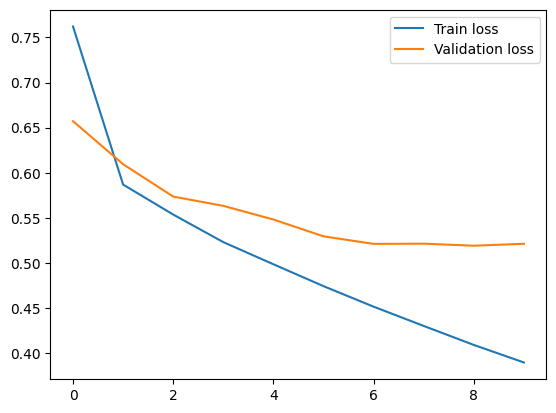

In [16]:
classifier = AmNewsClassifier(
    input_size=512,
    hidden_sizes=[64, 16],
    output_size=6
)

train_accuracy = classifier.evaluate(Tensor(X_train), Tensor(y_train))
test_accuracy = classifier.evaluate(Tensor(X_test), Tensor(y_test))
print("Test accuracy before training:", test_accuracy)
print("Train accuracy before training:", train_accuracy)

train_losses, val_losses = classifier.fit(train_loader, val_loader, epochs=10, lr=0.001, verbose=True)

plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.show()

### Model Evaluation Results
After training the classifier, we evaluate its performance on both the training and testing datasets:

1. **Accuracy on Training Data**:
   - The model achieves a **training accuracy of 87.07%**, indicating that it has effectively learned the patterns in the training dataset.

2. **Accuracy on Testing Data**:
   - The model achieves a **testing accuracy of 81.67%**, demonstrating its ability to generalize and classify unseen data accurately.

These results highlight the model's balanced performance, with good accuracy on both the training and testing datasets, suggesting minimal overfitting.


In [17]:
train_accuracy = classifier.evaluate(Tensor(X_train), Tensor(y_train))
test_accuracy = classifier.evaluate(Tensor(X_test), Tensor(y_test))
print("Test accuracy:", test_accuracy)
print("Train accuracy:", train_accuracy)

Test accuracy: 0.8166536688804626
Train accuracy: 0.8706521987915039


In [18]:
mapping = data.drop_duplicates(subset="category").set_index("category_num")["category"].to_dict()

saved_model = SavedModel(
    classifier,
    mapping
)

example_text = """
    አዋጁ የጸደቀው የሚኒስትሮች ምክር ቤት የባንክ ዘርፍን ለውጭ ኢንቨስተሮች ክፍት የሚያደርገው ፖሊሲ በስራ ላይ እንዲውል ከወሰነ ከሁለት ዓመታት በኋላ ነው።
    የሚኒስትሮች ምክር ቤት በነሐሴ 2014 ዓ.ም ባካሄደው ስብሰባ ነበር ይህን ውሳኔ ያስተላለፈው።
    ይህን ውሳኔ ተከትሎ ባለፈው ዓመት ሰኔ ወር ላይ ይህን የፖሊሲ ውሳኔ ወደ መሬት የሚያወርድ ረቂቅ አዋጅ ለህዝብ ተወካዮች ምክር ቤት ቀርቦ ነበር። ረቂቅ አዋጁ ከአምስት ወራት በኋላ ታኅሳስ 8፤ 2017 ዓ.ም. በፓርላማው ጸድቋል።
    ትናንት የጸደቀው አዋጅ "ጥንቃቄ በተዘጋጀ የሕግ እና የቁጥጥር ማዕቀፍ መሰረት የባንክ ዘርፍን ለውጭ ኢንቨስትመንት ክፍት ማድረግ የዘርፉን ተወዳዳሪነትና ውጤታማነት በማሻሻል ለዘላቂ የኢኮኖሚ ዕድገት አስተዋጽኦ ያደርጋል ተብሎ የሚታመን" መሆኑን ያስረዳል።
    በአዋጁ መሰረት "ማንኛውም የውጭ ባንክ በከፊል ወይም ሙሉ በሙሉ በባለቤትነት" የሚይዙት ተቀጥላ፣ ውጭ ባንክ ቅርንጫፍ ወይም እንደራሴ ቢሮ እንዲከፍቱ ይፈቀድላቸዋል።
    ከዚህ በተጨማሪ የውጭ ባንኮች በኢትዮጵያ ባንኮች ውስጥ አክሲዮን ባለቤቶች መሆን ይችላሉ።
    አዋጁ የውጭ ኢንቨስተሮች በአንድ የአገር ውስጥ ባንክ የሚይዙት የአክሲዮን ድርሻ "ከባንኩ አጠቃላይ የተፈረመ ካፒታል ከአርባ በመቶ መብለጥ አይችልም" የሚል ድንጋጌ አለው።
"""

print(saved_model.predict(example_text, vectorizer))

Business


c:\Users\Hp\Documents\aau\NLP\course project\am-news-classification\models\classifier.py:93: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  vector = torch.Tensor([vectorizer.transform([text]).toarray()])


In [19]:
with open("../models/trained/news_classifier_am.pkl", "wb") as f:
    pickle.dump(saved_model, f)

In [20]:
with open("../models/trained/news_classifier_am.pkl", "rb") as f:
    s_m: SavedModel = pickle.load(f)
s_m.predict(example_text, vectorizer)

'Business'

## Model Evaluation:

We will evaluate the performance of our `AmNewsClassifier` using the confusion matrix, which shows the model's predictions for each category, helping us identify misclassifications and performance issues.


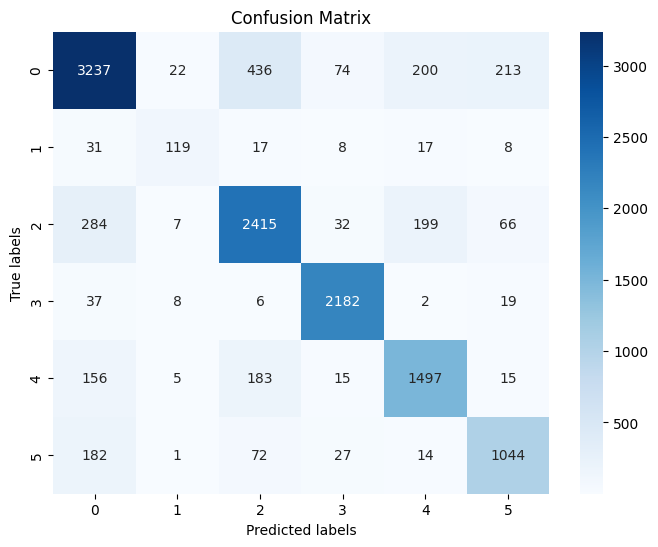

In [ ]:
with torch.no_grad():
    classifier.eval()
    y_pred = []
    y_true = []
    
    
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch, y_batch
        output = classifier(X_batch)
        _, preds = torch.max(output, dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

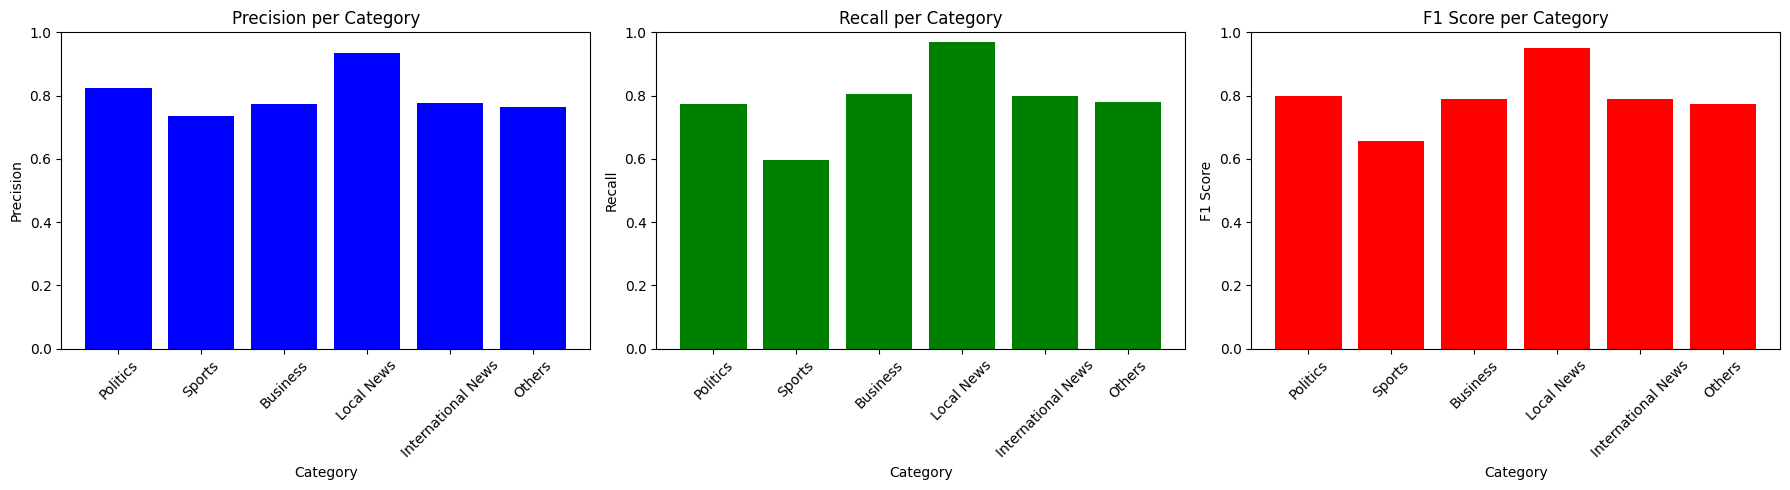

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

category_names = data['category'].unique()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Precision Plot
axes[0].bar(category_names, precision, color='blue')
axes[0].set_title('Precision per Category')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Precision')
axes[0].set_ylim([0, 1])
axes[0].tick_params(axis='x', rotation=45)

# Recall Plot
axes[1].bar(category_names, recall, color='green')
axes[1].set_title('Recall per Category')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Recall')
axes[1].set_ylim([0, 1])
axes[1].tick_params(axis='x', rotation=45)

# F1 Score Plot
axes[2].bar(category_names, f1, color='red')
axes[2].set_title('F1 Score per Category')
axes[2].set_xlabel('Category')
axes[2].set_ylabel('F1 Score')
axes[2].set_ylim([0, 1])
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### Conclusion:

The model performs well with high precision, recall, and F1 scores across most classes. Notably, **Local News** excels with a precision of 0.93 and recall of 0.97. While **Sports** has slightly lower recall, overall, the model is accurate and consistent, with most classes achieving F1 scores above 0.8.
